In [1]:
#! /usr/bin/env python
# Test photometry
# Simple plots eg. colour-colour
# Match and compare deep data to wide, per galaxy

!jupyter nbconvert --to script TestPhotometry_deep.ipynb

from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py as h
from astropy.table import Table,join

[NbConvertApp] Converting notebook TestPhotometry_deep.ipynb to script
[NbConvertApp] Writing 13431 bytes to TestPhotometry_deep.py


In [29]:
#READ IN DEEP CATALOGUE
#read in Erin's catalogue
#file='/global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-vd03-SN-C3_C01_r3688p01.fits' #c3 9band
#file='/global/project/projectdirs/des/y3-image-sims/deep_data/run-d02-SN-C3_all_r3688p01.fits' #c3grizonly 
file='/global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-vd03-SN-C3_trim_extcorr.fits' #c3 9band dered 
#c3grizonlydered
#file='/global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-d03-SN-C3_ebv_extcorr.fits' #c3grizonlydered
label="C39band_dered"
data = fits.open(file) 
data.info() 
print(data.info)
deep=Table(data[1].data)
cols = data[1].columns
print(cols)

#allmofs = []
#for i in np.arange(62):
#    fname = "/global/homes/a/aamon/DES/DEStests/DEEP/MOFcats/SN-C3/d03/run-d03-SN-C3_C{:02d}_r3688p01.fits".format(i+1) #c3 griz only- updated blending
#    try:
#        allmofs.append(fitsio.read(fname))
#    except:
#        pass
#deep = np.hstack(allmofs)
#print(deep.dtype)
print(min(deep['ra']),max(deep['ra']))
#deep=Table(allmofs)
#cols = allmofs[1].columns
############MAKE CUTS ON CAT
print("num deep galaxies :",len(deep))
deep=deep[deep['flags']==0]
#deep=deep[deep['bdf_s2n']>10]
#and a rough bright star-galaxy separation (removing bdf_s2n>80 and bdf_T<0 objects*************
#deep=deep[deep['bdf_s2n']<80]
#deep=deep[deep['bdf_T']<0]
print(min(deep['ra']),max(deep['ra']))
print("num deep good galaxies :",len(deep))
#deep=deep[deep['bdf_mag']<26] #############maybe should be 25.5 given Niall's imsim plots*******
#flags=0, bdf_s2n>10, mag_i<24.5, and a rough bright star-galaxy separation (removing bdf_s2n>80 and bdf_T<0 objects


Filename: /global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-vd03-SN-C3_trim_extcorr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  model_fits    1 BinTableHDU     55   855577R x 21C   [K, D, D, K, J, 11A, 2D, 4D, D, D, D, 9D, 9D, 9D, D, D, D, 9D, 9D, 9D, 9D]   
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2aaae38550d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaad71f6910>]>
ColDefs(
    name = 'id'; format = 'K'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'fof_id'; format = 'K'
    name = 'flags'; format = 'J'
    name = 'flagstr'; format = '11A'
    name = 'bdf_g'; format = '2D'
    name = 'bdf_g_cov'; format = '4D'; dim = '(2,2)'
    name = 'bdf_T'; format = 'D'
    name = 'bdf_T_err'; format = 'D'
    name = 'bdf_T_ratio'; format = 'D'
    name = 'bdf_flux'; format = '9D'
    name = 'bdf_mag'; format = '9D'
    name = 'bdf_flux_err';

In [30]:
#READ IN GOLD
catname = '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18.h5'

f = h.File(catname,'r')
print(f['catalog'].keys())
print(f['catalog/gold'].keys())
print(f['catalog/gold/coadd_object_id'])


ra = np.array(f['catalog/gold/ra'])#[star_mask] 
dec = np.array(f['catalog/gold/dec'])#[star_mask]
gflag = np.array(f['catalog/gold/flags_gold'])
badflag =  np.array(f['catalog/gold/flags_badregions'])
print(len(ra))

zeropt=30
g = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_g']))#[star_mask]
r = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_r']))#[star_mask]
i = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_i']))#[star_mask]
z = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_z']))#[star_mask]

"""cosmosonly=np.where(  (ra<max(deep['ra'])) & (ra>min(deep['ra']))
               &  (dec<max(deep['dec'])) & (dec>min(deep['dec']))   )
i=i[cosmosonly]
z=z[cosmosonly]
r=r[cosmosonly]
print(len(r))"""

"""
ra=ra[np.where((i<30) & (i>0))]
dec=dec[np.where((i<30)& (i>0))]
z=z[np.where((i<30)& (i>0))]
r=r[np.where((i<30)& (i>0))]
i=i[np.where((i<30)& (i>0))]
g=g[np.where((i<30)& (i>0))]
print(len(ra))
"""
ra[ra > 180] -= 360

#cutting out only galaxies
#If you are using MOF quantities, (FLAGS_GOLD & 1111001) = 0; and (FLAGS_BADREGIONS & 10) = 0
ra=ra[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
dec=dec[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
g=g[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
r=r[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
i=i[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
z=z[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]

gold=np.column_stack((ra,dec,g,r,i,z))
print(len(gold))
goldra=gold[:,0]
golddec=gold[:,1]
goldg=gold[:,2]
goldr=gold[:,3]
goldi=gold[:,4]
goldz=gold[:,5]


[u'metacal', u'gold', u'bpz', u'dnf', u'redmagic', u'redmapper']
[u'a_sed_sfd98_g', u'a_sed_sfd98_i', u'a_sed_sfd98_r', u'a_sed_sfd98_z', u'coadd_object_id', u'dec', u'delta_mag_chrom_g', u'delta_mag_chrom_i', u'delta_mag_chrom_r', u'delta_mag_chrom_z', u'delta_mag_y4_g', u'delta_mag_y4_i', u'delta_mag_y4_r', u'delta_mag_y4_z', u'ebv_sfd98', u'flags', u'flags_badregions', u'flags_footprint', u'flags_foreground', u'flags_gold', u'flags_phot', u'hpix_16384', u'n_images_g', u'n_images_i', u'n_images_r', u'n_images_z', u'ra', u'sextractor_flags_g', u'sextractor_flags_i', u'sextractor_flags_r', u'sextractor_flags_z', u'sof_cm_flux_corrected_g', u'sof_cm_flux_corrected_i', u'sof_cm_flux_corrected_r', u'sof_cm_flux_corrected_z', u'sof_cm_flux_err_g', u'sof_cm_flux_err_i', u'sof_cm_flux_err_r', u'sof_cm_flux_err_z', u'sof_cm_mag_corrected_g', u'sof_cm_mag_corrected_i', u'sof_cm_mag_corrected_r', u'sof_cm_mag_corrected_z', u'sof_cm_mag_err_g', u'sof_cm_mag_err_i', u'sof_cm_mag_err_r', u'sof_cm_

/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in l

377690605


In [31]:
#print(deep['bdf_mag_dered'][:,2]) #u gri z YJHKs
print(deep['bdf_mag'][:,2]) 
#print(len(deep['mag_auto']))

#ASSUMING MAGS ARE UGRI Z YJHKS
deepra=deep['ra']
deepdec=deep['dec']
#deepu=deep['bdf_mag'][:,0]
""" #for fourband, not dered
deepg=deep['bdf_mag'][:,0] #_dered
deepr=deep['bdf_mag'][:,1]
deepi=deep['bdf_mag'][:,2]
deepz=deep['bdf_mag'][:,3]

#for 9band- not dered
deepg=deep['bdf_mag'][:,1]
deepr=deep['bdf_mag'][:,2]
deepi=deep['bdf_mag'][:,3]
deepz=deep['bdf_mag'][:,4]
"""
#for 9band- dered
deepg=deep['bdf_mag_dered'][:,1]
deepr=deep['bdf_mag_dered'][:,2]
deepi=deep['bdf_mag_dered'][:,3]
deepz=deep['bdf_mag_dered'][:,4]


#SCALE CUTS
deepra=deepra[deepr>0]
deepdec=deepdec[deepr>0]
#deepu=deepu[deepr>0]
deepi=deepi[deepr>0]
deepg=deepg[deepr>0]
deepr=deepr[deepr>0]

print(len(deepra))
deepra=deepra[deepi>0]
deepdec=deepdec[deepi>0]
#deepu=deepu[deepi>0]
deepr=deepr[deepi>0]
deepg=deepg[deepi>0]
deepi=deepi[deepi>0]

deepra=deepra[deepg>0]
deepdec=deepdec[deepg>0]
#deepu=deepu[deepg>0]
deepr=deepr[deepg>0]
deepi=deepi[deepg>0]
deepg=deepg[deepg>0]

"""deepra=deepra[deepz>0]
deepdec=deepdec[deepz>0]
#deepu=deepu[deepz>0]
deepr=deepr[deepz>0]
deepi=deepi[deepz>0]
deepg=deepg[deepz>0]"""

"""deepra=deepra[deepu>0]
deepdec=deepdec[deepu>0]
deepr=deepr[deepu>0]
deepi=deepi[deepu>0]
deepg=deepg[deepu>0]
deepu=deepu[deepu>0]"""

print(len(deepra))

#print(deep['id'])
#print(deep['ra']


   bdf_mag   
-------------
23.6675714292
25.3366989088
20.7522290926
25.4079351421
23.2187596201
25.5659576035
25.1253881806
25.1168850498
26.8379877298
25.6017252328
          ...
 25.727936581
25.7564492799
 24.369799258
25.2770522051
24.5378332087
 23.749253263
22.1274175425
23.7997483495
21.5618033795
24.4435451599
24.3027673449
Length = 680711 rows
680711
680711


In [32]:
#match galaxies by ra and dec

from astropy.coordinates import SkyCoord
from astropy import units as u

goldcat = SkyCoord(ra=goldra*u.degree, dec=golddec*u.degree)  
catalog = SkyCoord(ra=deepra*u.degree, dec=deepdec*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(goldcat, nthneighbor=1) 

print(goldra[idx])


[ 52.18049819  52.22298942  52.43635611 ...,  36.3463004   36.57768165
  36.45904206]


377690605
680711
680711
[0d00m00.1902s 0d00m10.9245s 0d00m00.1917s ..., 0d00m00.1581s 0d00m06.435s
 0d00m07.4803s]
[  0.19017308  10.92449632   0.19169229 ...,   0.15814069   6.43495064
   7.48025978]
      ra     
-------------
52.1805378642
52.4364117585
52.2805617589
 52.164644634
52.1447445346
52.2410897734
52.2242971836
52.2367092019
52.4147602403
52.2765989835
          ...
36.5164776471
36.3155435915
36.3715922835
36.4845144469
36.4013680777
36.5648909222
36.4523524609
36.3473826208
36.3463414468
36.5791113176
36.4589312926
Length = 584098 rows


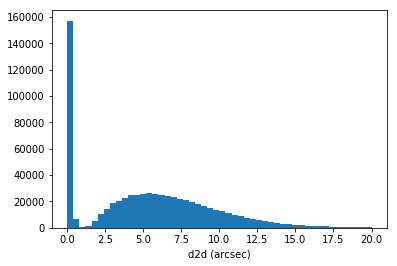

In [33]:
print(len(goldra)) 
print(len(deep['bdf_mag'])) 
print(len(d2d))  
print(d2d)
print(d2d.arcsecond)
plt.hist(d2d.arcsecond, 50, range=(0, 20)) #20 is the max matching range in arcmin
plt.xlabel('d2d (arcsec)')
print(deepra[d2d.arcsecond < 10])

35.9834927041 53.3807205254
35.9865699233 53.3795757156


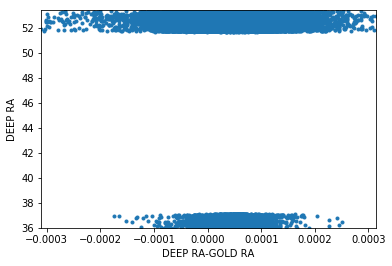

In [34]:
matchlim=1
plt.scatter(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)],deepra[np.where(d2d.arcsecond < matchlim)], marker='.')
plt.xlabel('DEEP RA-GOLD RA')
plt.ylabel('DEEP RA')
plt.ticklabel_format(useOffset=False)
#plt.xlim(min(goldra[idx][np.where(d2d < matchlim)]),max(goldra[idx][np.where(d2d < matchlim)]) )
plt.ylim(min(deepra[np.where(d2d.arcsecond < matchlim)]),max(deepra[np.where(d2d.arcsecond < matchlim)]) )
plt.xlim(min(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)]),max(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)]) )
print(min(goldra[idx]),max(goldra[idx]) )
print(min(deepra),max(deepra))

In [35]:
match=np.column_stack((goldg[idx][np.where(d2d.arcsecond < matchlim)], deepg[np.where(d2d.arcsecond < matchlim)],  
                       goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 
                       goldi[idx][np.where(d2d.arcsecond < matchlim)], deepi[np.where(d2d.arcsecond < matchlim)], 
                       goldz[idx][np.where(d2d.arcsecond < matchlim)], deepz[np.where(d2d.arcsecond < matchlim)],
                       goldra[idx][np.where(d2d.arcsecond < matchlim)], deepra[np.where(d2d.arcsecond < matchlim)]))

print("percentage matched: ", float(len(deepr[np.where(d2d.arcsecond < matchlim)]))/float(len(deepr))*100.)
print(np.shape(match))
#gold deep
#g 01
#r 23
#i 45
#z 67

#CUTS ON MGNITUDES
#gold < 22) & (deep < 22)  
maglim=30
match=match[np.where( (match[:,0] < maglim) & (match[:,1] < maglim) )]
print(np.shape(match))
match=match[np.where( (match[:,2] < maglim))]  #& (match[:,3] < 22) )]
match=match[np.where( match[:,3] < 22)] #rdeep cut

print(np.shape(match))
match=match[np.where( (match[:,4] < maglim) & (match[:,5] < maglim) )]
print(np.shape(match))
match=match[np.where( (match[:,6] < maglim) & (match[:,7] < maglim) )]
print(np.shape(match))

"""
#CUTS ON MAGNITUDE SUMS
#GB: take the median mag difference of objects with 0.5*(gold+deep) < 22
#We don’t want selection or noise biases to bias the measurement of this offset, so we want to restrict to mags where both catalogs are complete.

magsumlim=60
rsum=  match[:,2]+match[:,3]
print(rsum)
match=match[np.where(rsum < magsumlim)]
rsum=rsum[np.where(rsum < magsumlim)]
print(rsum)
print(np.shape(match))
print(match[:,8])
print("***")
print(match[:,9])

gsum=  match[:,0]+match[:,1]
match=match[np.where(gsum < magsumlim)]
print(np.shape(match))

isum=  match[:,4]+match[:,5]
match=match[np.where(isum < magsumlim)]
print(np.shape(match))

zsum=  match[:,6]+match[:,7]
match=match[np.where(zsum < magsumlim)]
print(np.shape(match))
"""
goldgselect=match[:,0]
deepgselect=match[:,1]

goldrselect=match[:,2]
deeprselect=match[:,3]

goldiselect=match[:,4]
deepiselect=match[:,5]

goldzselect=match[:,6]
deepzselect=match[:,7]

"""goldg=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
goldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
goldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
print(len(goldr[idx][np.where(d2d.arcsecond < matchlim)]))
print(len(goldrselect))
print(rsum)

#usum=  goldu[idx][np.where(d2d.arcsecond < matchlim)] + deepu[np.where(d2d.arcsecond < matchlim)] 
#golduselect=goldu[idx][np.where(d2d.arcsecond < matchlim)][np.where(usum < 44)]
print(len(goldg))
gsum=  goldg[idx][np.where(d2d.arcsecond < matchlim)] + deepg[np.where(d2d.arcsecond < matchlim)] 
goldgselect=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldrselect=goldrselect[np.where(gsum < 44)]
print(len(goldgselect))

isum=  goldi[idx][np.where(d2d.arcsecond < matchlim)] + deepi[np.where(d2d.arcsecond < matchlim)] 
goldiselect=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(isum < 44)]
print(len(goldiselect))

zsum=  goldz[idx][np.where(d2d.arcsecond < matchlim)] + deepz[np.where(d2d.arcsecond < matchlim)] 
goldzselect=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(zsum < 44)]
print(len(goldzselect))"""

percentage matched:  24.0743869278
(163877, 10)
(162181, 10)
(23269, 10)
(23268, 10)
(23267, 10)


'goldg=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]\ngoldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]\ngoldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]\nprint(len(goldr[idx][np.where(d2d.arcsecond < matchlim)]))\nprint(len(goldrselect))\nprint(rsum)\n\n#usum=  goldu[idx][np.where(d2d.arcsecond < matchlim)] + deepu[np.where(d2d.arcsecond < matchlim)] \n#golduselect=goldu[idx][np.where(d2d.arcsecond < matchlim)][np.where(usum < 44)]\nprint(len(goldg))\ngsum=  goldg[idx][np.where(d2d.arcsecond < matchlim)] + deepg[np.where(d2d.arcsecond < matchlim)] \ngoldgselect=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]\ngoldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]\ngoldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]\ngoldrselect=goldrselect[np.where(gsum < 44)]\nprint(len(goldgselect))\n\nisum=  goldi[idx][np.where(d2d.arcsecond < matchlim)] + deepi[np.whe

680711
680711
23267
***
23267


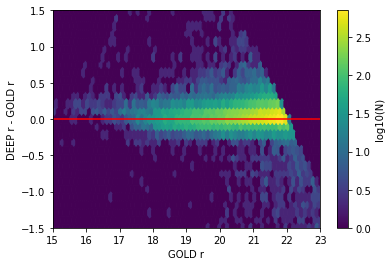

In [36]:
#plot magnitudes
#print(len(goldr[idx][np.where(d2d.arcsecond < matchlim)]))
#print(len(deep['bdf_mag'][np.where(d2d.arcsecond < matchlim)]))


#fit = np.polyfit(goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 1)
#fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
print(len(deepr))
print(len(deepr[deepr>0]))
#plt.plot(goldr[idx][np.where(d2d.arcsecond < matchlim)], fit_fn(goldr[idx][np.where(d2d.arcsecond < matchlim)]), '--k')
#x = np.linspace(14, 40, 1000)
#plt.plot(x,x,color='red')

print(len(goldrselect))
print("***")
print(len(deeprselect))

fig, ax = plt.subplots()
hb=ax.hexbin(goldrselect, deeprselect-goldrselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(15,23)
plt.axhline(y=0, color='red')
plt.ylim(-1.5,1.5)
plt.xlabel('GOLD r')
plt.ylabel('DEEP r - GOLD r')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltar_v_goldr_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

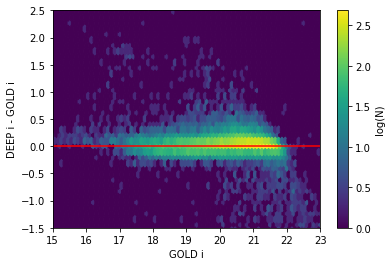

In [37]:
#plot magnitudes

#fit = np.polyfit(goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 1)
#fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
#plt.plot(goldr[idx][np.where(d2d.arcsecond < matchlim)], fit_fn(goldr[idx][np.where(d2d.arcsecond < matchlim)]), '--k')
#x = np.linspace(14, 40, 1000)
#plt.plot(x,x,color='red')



fig, ax = plt.subplots()
hb=ax.hexbin(goldiselect, deepiselect-goldiselect, bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
#plt.scatter(goldiselect, deepiselect-goldiselect, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log(N)')

plt.xlabel('GOLD i')
plt.ylabel('DEEP i - GOLD i')
name="Figs/deltai_v_goldi_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

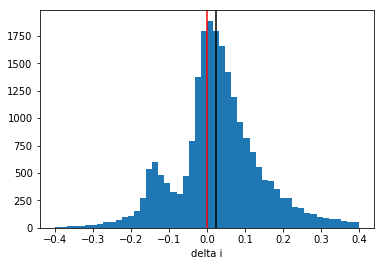

In [38]:
plt.hist(deepiselect-goldiselect, 50, range=(-0.4, 0.4))
plt.axvline(x=0, color='red')
plt.axvline(x=np.median(deepiselect-goldiselect), color='black')
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta i')
name="Figs/deltai_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

0.0367609011883


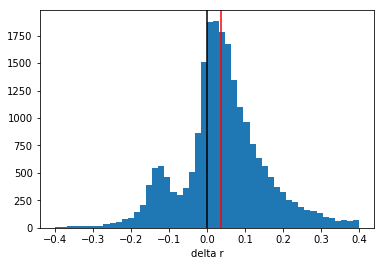

In [39]:
plt.hist(deeprselect-goldrselect, 50, range=(-0.4, 0.4))
plt.axvline(x=0, color='black')
print(np.median(deeprselect-goldrselect))
plt.axvline(x=np.median(deeprselect-goldrselect), color='red')
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta r')
name="Figs/deltar_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

#colour-colour
plt.scatter(deeprselect-deepiselect,deepgselect-deeprselect, marker='.') #,markersize=10 )
plt.xlabel('r-i')
plt.ylabel('g-r')

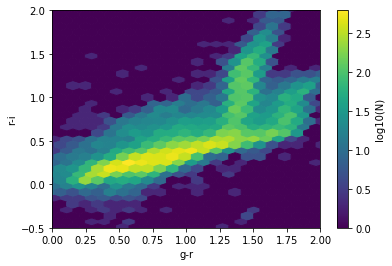

In [40]:
fig, ax = plt.subplots()
hb=ax.hexbin(deepgselect-deeprselect,deeprselect-deepiselect ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
#plt.scatter(deepgselect-deeprselect,deeprselect-deepiselect,marker='.', facecolors='blue', color='blue',alpha=0.2)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.xlim(-1.5,3)
#plt.ylim(-1.5,3)
plt.xlim(0,2)
plt.ylim(-0.5,2.0)
name="Figs/r-i_v_g-r_matched_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)